In [21]:
!export CUDA_VISIBLE_DEVICES=0

import os, torch, pdb

import numpy as np 
import networkx as nx
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import plot, init_notebook_mode, iplot
import plotly.express as px

from rdkit.Chem import AllChem

from escnn import gspaces, nn, group


from vae_dist.dataset.fields import mat_pull, split_and_filter
from vae_dist.dataset.dataset import FieldDataset, dataset_split_loader
from vae_dist.core.O3CNN import R3Net


init_notebook_mode(connected=True)


In [22]:
groupie = group.o3_group()
group_space = gspaces.flipRot3dOnR3(maximum_frequency=10) 
input_out_reps = 3*[group_space.trivial_repr]
kernel_size = 5
feat_type_in  = nn.FieldType(group_space,  input_out_reps) 
feat_type_out = nn.FieldType(group_space,  input_out_reps)   
pwd = os.getcwd()
ckpt_dir = "/log_version_auto_1/autoenc_1.ckpt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:

model = R3Net(
        0.0005,
        group_space,
        feat_type_in = feat_type_in, 
        feat_type_out = feat_type_out, 
        kernel_size=kernel_size,
        latent_dim=10, 
        fully_connected_dims=[100, 100, 100]
    )

model.load_model("./log_version_auto_1/autoenc_1.ckpt")

/home/santiagovargas/anaconda3/envs/bondnet_e3nn/lib/python3.7/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


48 100
100 100
100 10
Model Created!


In [23]:
model = model.cuda()

In [24]:
root = "../../data/augment_test/"
dataset_test = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )

dataset_loader_full = torch.utils.data.DataLoader(
        dataset_test, 
        batch_size=10,
        shuffle=True,
        num_workers=0
    )

Largest value in dataset:  0.9999994960772131
Smallest value in dataset:  -0.3471241882433806


In [25]:
root = "../../data/cpet/"

dataset = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )

Largest value in dataset:  0.9999921339414676
Smallest value in dataset:  -0.8579092372783054


# Latent Space Plotting

Total number of fields:  352


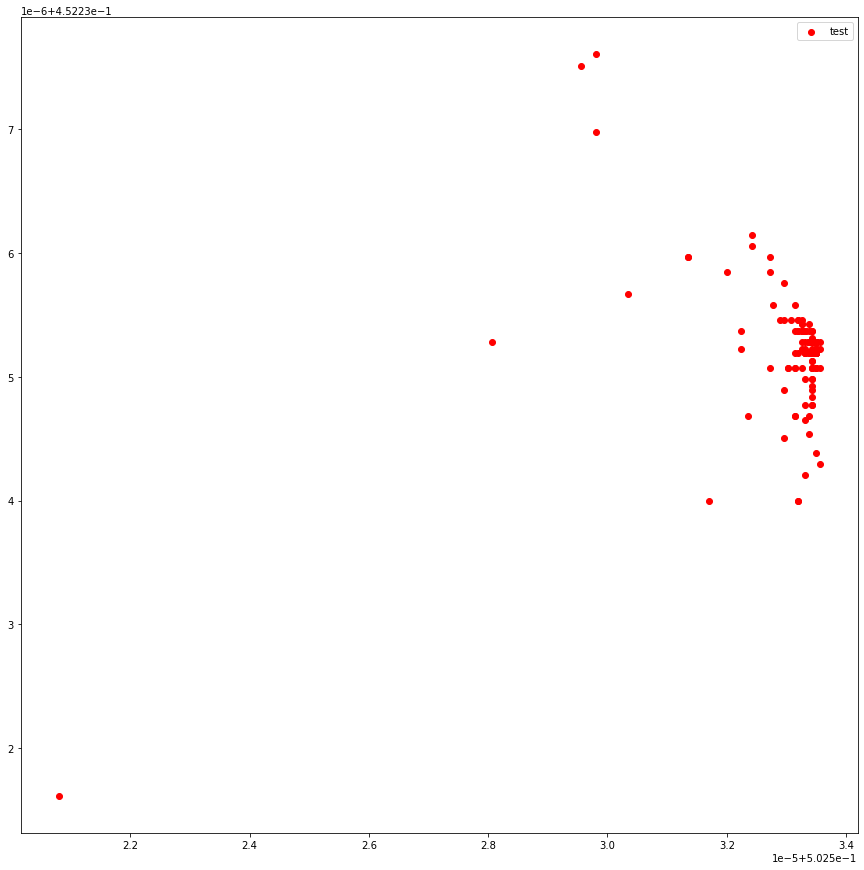

In [70]:

def get_latent_space(model, dataset, comp=[0, 2]):
    latent_space = []
    # convert load to numpy 
    dataset_loader_np = []
    print("Total number of fields: ", len(dataset))
    for ind in range(len(dataset)):

        field=dataset[ind].reshape(1, 3, 21, 21, 21)
        latent = model.encode(field)
        latent_space.append(latent.detach().cpu().numpy())
        
    return np.array(latent_space).reshape(-1, 10)[:, comp]


plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
plt.legend()
plt.show()

Largest value in dataset:  0.9999994960772131
Smallest value in dataset:  -0.3471241882433806
Total number of fields:  352
Total number of fields:  8


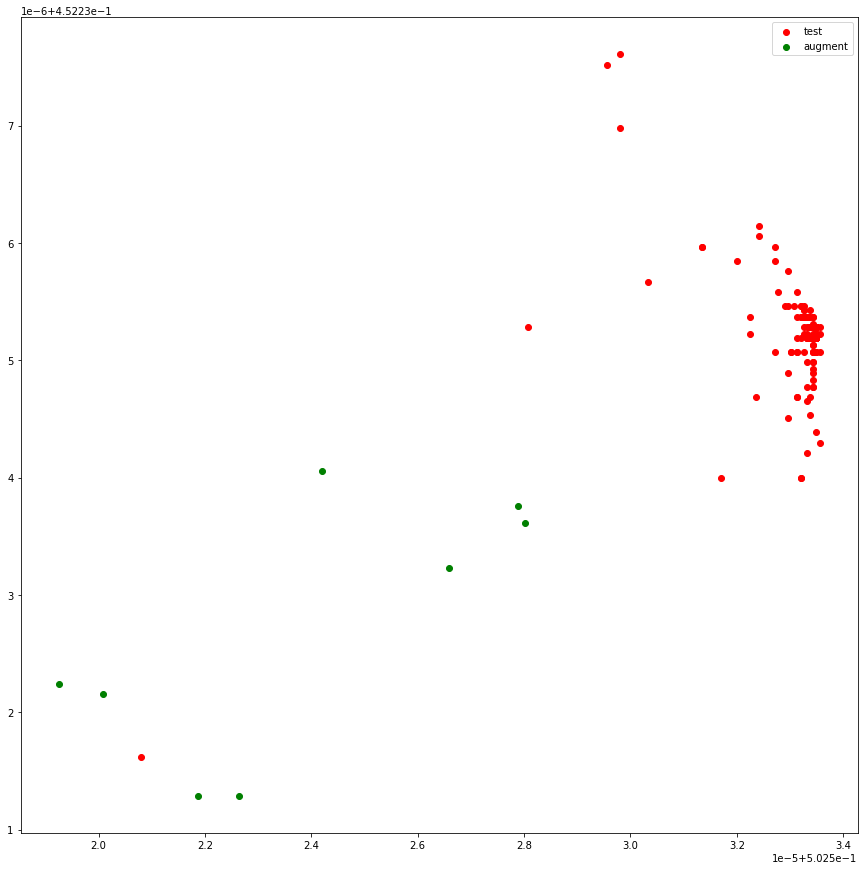

In [76]:
# Rotations on latent space

root = "../../data/augment_test/"
dataset_aug = FieldDataset(
    root, 
    transform=False, 
    augmentation=False,
    standardize=True,
    device=device
    )


plt.figure(figsize=(15, 15))
latent_space = get_latent_space(model, dataset, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="red", label="test")
latent_space = get_latent_space(model, dataset_aug, comp=[0, 1])
plt.scatter(latent_space[:, 0], latent_space[:, 1], c="green", label="augment")

plt.legend()
plt.show()



# run the equivariance test


In [11]:


def equiv_test(model, dataset_test, device):
    print('##########################################################################################')
    with torch.no_grad():
        #x = next(iter(dataset_test)).reshape(1, 3, 21, 21, 21).to(device)
        x = dataset_test[0].reshape(1, 3, 21, 21, 21).to(device)
        y = model(x).to('cpu')
        print("Outputs' magnitudes")
        print(torch.linalg.norm(y, dim=1).numpy().reshape(-1))
        # print largest value 
        print("Largest value")
        print(torch.max(torch.linalg.norm(y, dim=1)).numpy())
        print('##########################################################################################')
        print("Errors' magnitudes")
        for r in range(8):
            # sample a random rotation
            g = groupie.sample()
            x_equi = feat_type_in(dataset_test[r].reshape(1, 3, 21, 21, 21).to(device))
            x_transformed = g @ x_equi
            x_transformed = x_transformed.to(device)
            y_transformed = model(x).to('cpu')
            
            y_group_rep = feat_type_in(y)
            # verify that f(g@x) = g@f(x)=g@y
            # print maximum error
            #print(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1).numpy().reshape(-1))        
            print("Largest error")
            print(torch.max(torch.linalg.norm(y_transformed - (g@y_group_rep).tensor, dim=1)).numpy())
    print('##########################################################################################')
    print()
equiv_test(model, dataset_test, device)

##########################################################################################
Outputs' magnitudes
[3.063006e-05 3.063006e-05 3.063006e-05 ... 3.063006e-05 3.063006e-05
 3.063006e-05]
Largest value
0.75596917
##########################################################################################
Errors' magnitudes
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
Largest error
7.450581e-09
##########################################################################################



In [109]:
model_fresh = R3Net(
        0.0005,
        group_space,
        feat_type_in = feat_type_in, 
        feat_type_out = feat_type_out, 
        kernel_size=kernel_size,
        latent_dim=10, 
        fully_connected_dims=[100, 100, 100]
    )
model_fresh = model_fresh.cuda()
equiv_test(model_fresh, dataset_test, device)

48 100
100 100
100 10
##########################################################################################
Outputs' magnitudes
[2.8252327e-05 2.8252327e-05 2.8252327e-05 ... 2.8252327e-05 2.8252327e-05
 2.8252327e-05]
Largest value
0.26404372
##########################################################################################
Errors' magnitudes
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
Largest error
0.0
##########################################################################################



# Visualize in/out field from model


In [17]:

def plot_vfield(mat, cutoff = 95, min_max = True):
        x = mat #dataset_test.data[0] 
        x = x.reshape(21, 21, 21, 3)
        u_1, v_1, w_1 = split_and_filter(x, min_max = min_max, cutoff = cutoff)    
        a, b, c = np.meshgrid(
                np.arange(-3, 3.3, 0.3),
                np.arange(-3, 3.3, 0.3),
                np.arange(-3, 3.3, 0.3)
                )

        #max value of each dimension
        max_u = np.max(u_1)
        max_v = np.max(v_1)
        max_w = np.max(w_1)
        print(max_u, max_v, max_w)
        scale = 1

        cones = go.Cone(
                x=a.flatten(), 
                y=b.flatten(), 
                z=c.flatten(), 
                u=u_1 * scale,
                v=v_1 * scale, 
                w=w_1 * scale)
                #sizeref=0.5,)
                #opacity=0.0) 
                
        layout = go.Layout(
                title='Cones',
                width=700,
                height=700,
                        #sizeref=0.5,
                        #anchor='tail'
                )

        fig = go.Figure(data=cones,layout=layout)
        iplot(fig)


plot_vfield(dataset_test.data[1], cutoff = 90, min_max = True)
#fig.show()
#fig.write_html("cones_.html")

0.83 0.88 1.0


In [20]:
# model reconstruction

x = dataset_test[3].reshape(1, 3, 21, 21, 21).to(device)
x_out = model(x)
x_out = x_out.to('cpu').detach().numpy().reshape(3, 21, 21, 21)

plot_vfield(x_out, cutoff = 00, min_max = True)


1.0 1.0 1.0
